In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from time import time
from sympy import Symbol, diff, lambdify, sin, exp

In [3]:
#przedział funkcji
a = -4*math.pi
b = 3*math.pi
#liczba punktów na wykresach i przy obliczaniu błędów
points = 1000

In [4]:
def chebyshev_nodes(a, b, n):
    x = []
    for i in range(1, n + 1):
        x.append(0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * i - 1) / (2 * n) * np.pi))
    return x

In [5]:
def data_plot(xs, ys, label=''):
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(xs, ys)
    if label: plt.legend(loc="best")


def func_plot(fn, a, b, n, label='', color='', figsize=(6, 4), subplot=None, title=''):
    if subplot is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = subplot
    xs = np.linspace(a, b, num=n)
    ys = [fn(xi) for xi in xs]
    if color:
        ax.plot(xs, ys, label=label, color=color)
    else:
        ax.plot(xs, ys, label=label)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if label:
        ax.legend(loc="best")
    if title:
        ax.set_title(title)


In [6]:
def create_compare_errors_table(hermit_errors):
    data = {"Interpolacja Hermite'a":hermit_errors}
    df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    return df


In [7]:
def max_absolute_error(f, W, xs):
    return max([abs(f(x) - W(x)) for x in xs])


In [8]:
def mse(f, W, xs):
    return sum([(f(x) - W(x)) ** 2 for x in xs]) / len(xs)

In [9]:

def display_interpolation(f, a,b,n, interpolation, label,color=None,chebyshev=False, natural=True, title=""):
    xs = np.linspace(a,b, points)
    fig, ax = plt.subplots(figsize=(6, 4))
    W = interpolation(f,a,b,n,chebyshev=chebyshev,natural=natural, ax=ax)
    W_errors = [max_absolute_error(f, W ,xs), mse(f,W ,xs)]
    func_plot(f, a, b, 1000, label="f(x)", subplot=ax)
    if color is not None:
        func_plot(W, a, b, 1000, label=label, subplot=ax, color=color, title=title)
    else:
        func_plot(W, a, b, 1000, label=label, subplot=ax, title=title)

    plt.show()
    data = {label:W_errors}
    df = pd.DataFrame(data, index=["Błąd bezwzględny", "Błąd średniokwadratowy"])
    display(df)

In [19]:
class QuadraticSpline:
    def __init__(self, xs, ys):
        self.n = len(xs)
        self.xs = xs
        self.ys = ys
        self.functions = []
    def s(self, i,a,b,c):
        return lambda x: a[i]*(x-self.xs[i]) ** 2 + b[i]*(x-self.xs[i]) + c[i]
    def natural_spline(self):
        a = []
        b = [0]
        c = self.ys
        self.find_factors(a,b)
        self.find_functions(a,b,c)
        return self.interpolation_val
    def clamped_boundary(self):
        a = []
        b = [2*(self.ys[1]-self.ys[0])/(self.xs[1]-self.xs[0])]
        c = self.ys
        self.find_factors(a,b)
        self.find_functions(a,b,c)
        return self.interpolation_val
    def find_factors(self,a,b):
        for i in range(1, self.n):
            b.append(2*(self.ys[i]-self.ys[i-1])/(self.xs[i]-self.xs[i-1])-b[-1])
        for i in range(self.n - 1):
            a.append((b[i + 1] - b[i]) / (2 * (self.xs[i + 1] - self.xs[i])))

    def find_functions(self, a,b,c):
        for i in range(self.n-1):
            self.functions.append(self.s(i,a,b,c))

    def interpolation_val(self,x):
        index = 0
        if x < self.xs[0] or x>self.xs[-1]:
            return 0
        for i in range(self.n-1):
            if self.xs[i]<=x and self.xs[i+1]>=x:
                index = i
                break
        return self.functions[index](x)


In [11]:

def quadtratic_spline_func(f, a, b, n, chebyshev=False, natural=True,ax=None):
    if chebyshev:
        x = chebyshev_nodes(a, b, n)
    else:
        x = np.linspace(a, b, n)
    y = [f(xi) for xi in x]
    if ax is not None:
        ax.plot(x, y, 'o', c="r")
    if natural:
        return QuadraticSpline(x, y).natural_spline()
    return QuadraticSpline(x, y).clamped_boundary()

In [12]:
class CubicSpline:
    def __init__(self, xs, ys):
        self.n = len(xs)
        self.xs = xs
        self.ys = ys
        self.functions = []
        self.h = [xs[i + 1] - xs[i] for i in range(self.n - 1)]

    def s(self, i, b, c, d):
        return lambda x: self.ys[i] + b[i] * (x - self.xs[i]) + c[i] * (x - self.xs[i]) ** 2 + d[i] * (
                    x - self.xs[i]) ** 3

    def calculate_deltas_of_degree(self, degree):
        Δs = [list(self.ys)]
        for j in range(1, degree + 1):
            Δs.append([(Δs[j - 1][i + 1] - Δs[j - 1][i]) / (self.xs[i + j] - self.xs[i]) for i in range(self.n - j)])
        return Δs[degree]

    def cubic_spline_interpolation(self, natural=True):
        deltas_1 = self.calculate_deltas_of_degree(1)
        Y_vec = np.array([deltas_1[i + 1] - deltas_1[i] for i in range(len(deltas_1) - 1)])
        A_matrix = np.array([([0 for _ in range(j)] + [self.h[j], 2 * (self.h[j] + self.h[j + 1]), self.h[j + 1]] + [
            0 for _ in range(len(self.h) - 2 - j)])for j in range(len(self.h) - 1)])
        if natural:
            Y_vec, A_matrix = self.natural_spline(Y_vec, A_matrix)
        else:
            Y_vec, A_matrix = self.cube_spline(Y_vec, A_matrix)
        Y_vec = np.array(Y_vec, dtype=np.float64)
        A_matrix = np.array(A_matrix, dtype=np.float64)
        sigma = np.linalg.solve(A_matrix, Y_vec)

        b, c, d = self.find_factors(sigma)

        self.find_functions(b, c, d)
        return self.interpolation_val

    def natural_spline(self, Y_vec, A_matrix):
        h_len = len(self.h)
        deltas = self.calculate_deltas_of_degree(3)
        y_1 = self.h[1] ** 2 * deltas[0]
        y_n = -self.h[h_len - 1] ** 2 * deltas[-1]
        Y_vec = np.concatenate(([y_1], Y_vec, [y_n]))
        A_matrix = np.concatenate(([[1] + [0 for _ in range(h_len)]],
                                   A_matrix, [[0 for _ in range(h_len)] + [1]]), axis=0)

        return Y_vec, A_matrix

    def cube_spline(self, Y_vec, A_matrix):
        len_h = len(self.h)
        A_matrix = np.concatenate(([[-self.h[0], self.h[0]] + [0 for _ in range(len_h - 1)]],
                                   A_matrix, [[0 for _ in range(len_h - 1)] + [-self.h[len_h - 1], self.h[len_h - 1]]]),
                                  axis=0)
        Y_vec = np.concatenate(([0], Y_vec, [0]))

        return Y_vec, A_matrix

    def find_factors(self, sigma):
        b = [(self.ys[i + 1] - self.ys[i]) / self.h[i] - self.h[i] * (sigma[i + 1] + 2 * sigma[i]) for i in range(self
                                                                                                                  .n - 1)]
        c = [3 * sigma[i] for i in range(self.n - 1)]
        d = [(sigma[i + 1] - sigma[i]) / self.h[i] for i in range(self.n - 1)]
        return b, c, d

    def find_functions(self, b, c, d):
        for i in range(self.n - 1):
            self.functions.append(self.s(i, b, c, d))

    def interpolation_val(self, x):
        index = 0
        if x < self.xs[0] or x > self.xs[-1]:
            return 0
        for i in range(self.n - 1):
            if self.xs[i] <= x and self.xs[i + 1] >= x:
                index = i
                break
        return self.functions[index](x)


In [13]:
def cubic_spline_func(f, a, b, n, chebyshev=False, natural=True, ax=None):
    if chebyshev:
        x = chebyshev_nodes(a, b, n)
    else:
        x = np.linspace(a, b, n)
    y = [f(xi) for xi in x]
    if ax is not None:
        ax.plot(x, y, 'o', c="r")
    return CubicSpline(x, y).cubic_spline_interpolation(natural=natural)

In [14]:
f = lambda x, k=4, m=1: exp(-k * sin(m * x)) + k * sin(m * x) - 1

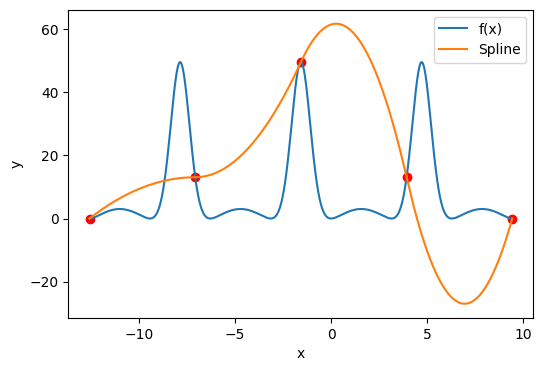

,Spline
Błąd bezwzględny,61.6029589661644
Błąd średniokwadratowy,906.374636476934


In [20]:
display_interpolation(f,a,b,5, quadtratic_spline_func,natural=False , label="Spline")

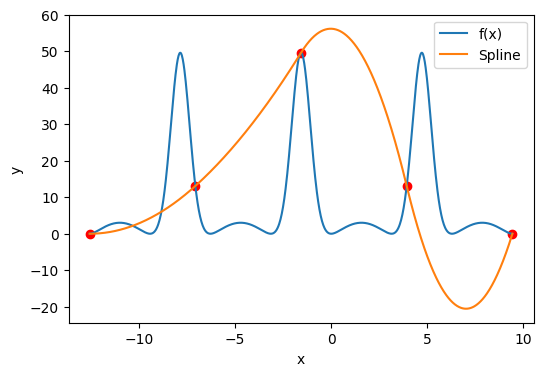

,Spline
Błąd bezwzględny,56.1754687728558
Błąd średniokwadratowy,801.886754018638


In [16]:
display_interpolation(f,a,b,5, quadtratic_spline_func, label="Spline")

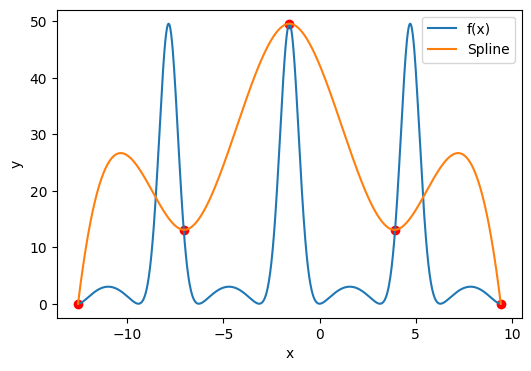

,Spline
Błąd bezwzględny,43.5522956695238
Błąd średniokwadratowy,583.230197735489


In [17]:
display_interpolation(f,a,b,5, cubic_spline_func, label="Spline")

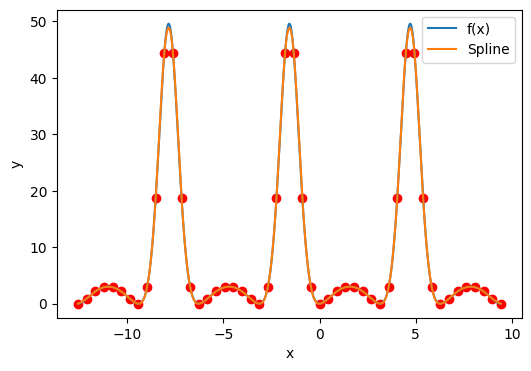

,Spline
Błąd bezwzględny,0.727467267276005
Błąd średniokwadratowy,0.0244379205724025


In [18]:
display_interpolation(f,a,b,50, cubic_spline_func, natural=False,label="Spline")